In [1]:
# | code-summary: code -- load dependencies and data and select parameters


from compmemlearn.fitting import generate_objective_function, apply_and_concatenate
from compmemlearn.datasets import events_metadata
from compmemlearn.datasets import simulate_df
from scipy.optimize import differential_evolution
from numba.typed import List, Dict
from numba.core import types
from numba import njit
from psifr import fr
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import importlib
import os

lb = np.finfo(float).eps
ub = 1 - np.finfo(float).eps

figure_caption = """Distribution of log-likelihood scores of recall sequences exhibited by each subject in dataset under each considered model."""

section_tag = "Murdock1962_2Subjects"

data_path = "../data/Murdock1962.csv"
results_path = "results/"
trial_query = "subject < 3"

model_paths = ["compmemlearn.models.Classic_CMR", "compmemlearn.models.Instance_CMR"]

model_names = ["PrototypeCMR", "InstanceCMR"]

free_parameters = [
    [
        'encoding_drift_rate',
        'start_drift_rate',
        'recall_drift_rate',
        'shared_support',
        'item_support',
        'learning_rate',
        'primacy_scale',
        'primacy_decay',
        'stop_probability_scale',
        'stop_probability_growth',
        'choice_sensitivity',
        'delay_drift_rate'
    ],
        [
        "encoding_drift_rate",
        "start_drift_rate",
        "recall_drift_rate",
        "shared_support",
        "item_support",
        "learning_rate",
        "primacy_scale",
        "primacy_decay",
        "stop_probability_scale",
        "stop_probability_growth",
        'choice_sensitivity',
        #    "context_sensitivity",
        #    "feature_sensitivity",
        "delay_drift_rate",
    ]
]

bounds = [
    [
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, 100),
    (lb, 100),
    (lb, ub),
    (lb, 10),
    (lb, 10),
    (lb, ub),
    ],
        [
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, 100],
        [lb, 100],
        [lb, ub],
        [lb, 10],
        [lb, 10],
        [lb, ub],
    ],
]

fixed_parameters = [
    {'sampling_rule': 0, 'mfc_familiarity_scale': 0, 
         'mcf_familiarity_scale': 0, 'drift_familiarity_scale': 0}, 
    {"context_sensitivity": 1, "feature_sensitivity": 1, 'mfc_familiarity_scale': 0, 
         'mcf_familiarity_scale': 0, 'drift_familiarity_scale': 0},
]

experiment_count = 100


In [4]:
# Parameters
data_path = "../data/HealyKahana2014.csv"
trial_query = "task == -1"
results_path = "results/"
model_paths = [
    "compmemlearn.models.Exp_ICMR",
    "compmemlearn.models.Lrn_ICMR",
    "compmemlearn.models.Instance_CMR",
]
model_names = ["Exp MFC Trace Scaling", "Lrn MFC Trace Scaling", "MFC Trace Scaling"]
free_parameters = [
    [
        "encoding_drift_rate",
        "start_drift_rate",
        "recall_drift_rate",
        "shared_support",
        "item_support",
        "learning_rate",
        "primacy_scale",
        "primacy_decay",
        "stop_probability_scale",
        "stop_probability_growth",
        "feature_sensitivity",
        "delay_drift_rate",
    ],
    [
        "encoding_drift_rate",
        "start_drift_rate",
        "recall_drift_rate",
        "shared_support",
        "item_support",
        "learning_rate",
        "primacy_scale",
        "primacy_decay",
        "stop_probability_scale",
        "stop_probability_growth",
        "feature_sensitivity",
        "delay_drift_rate",
    ],
    [
        "encoding_drift_rate",
        "start_drift_rate",
        "recall_drift_rate",
        "shared_support",
        "item_support",
        "learning_rate",
        "primacy_scale",
        "primacy_decay",
        "stop_probability_scale",
        "stop_probability_growth",
        "feature_sensitivity",
        "delay_drift_rate",
    ],
]
bounds = [
    [
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 0.9999999999999998],
    ],
    [
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 0.9999999999999998],
    ],
    [
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 0.9999999999999998],
    ],
]
fixed_parameters = [
    {
        "choice_sensitivity": 1,
        "context_sensitivity": 1,
        "mfc_familiarity_scale": 0,
        "mcf_familiarity_scale": 0,
        "drift_familiarity_scale": 0,
    },
    {
        "choice_sensitivity": 1,
        "context_sensitivity": 1,
        "mfc_familiarity_scale": 0,
        "mcf_familiarity_scale": 0,
        "drift_familiarity_scale": 0,
    },
    {
        "choice_sensitivity": 1,
        "context_sensitivity": 1,
        "mfc_familiarity_scale": 0,
        "mcf_familiarity_scale": 0,
        "drift_familiarity_scale": 0,
    },
]
section_tag = "Healy_Scaling_Mechanisms"


In [5]:
#| code-summary: code -- test that specified parameters are valid
#| output: false

events = pd.read_csv(data_path)

trials, list_lengths, presentations, trial_details = events_metadata(events, trial_query)

# import models from specified source
models = []
for i in range(len(model_paths)):
    module_name, model_name = model_paths[i].rsplit('.',1) #TODO: add handling for case with no `.`
    module = importlib.import_module(module_name)
    models.append(getattr(module, model_name))

# make sure model initializes with provided parameters and boundaries
for model_index, model_class in enumerate(models):

    @njit(fastmath=True, nogil=True)
    def init_model(item_count, presentation_count, parameters):
        return model_class(item_count, presentation_count, parameters)

    cost_function = generate_objective_function(
        events,
        trial_query,
        init_model,
        fixed_parameters[model_index],
        free_parameters[model_index],
    )
    
    for boundary_index in range(2):
        x = np.array([each[boundary_index] for each in bounds[model_index]])

        # parameter configuration
        parameters = Dict.empty(key_type=types.unicode_type, value_type=types.float64)
        for name, value in fixed_parameters[model_index].items():
            parameters[name] = value
        for i in range(len(free_parameters[model_index])):
                parameters[free_parameters[model_index][i]] = x[i]

        model = init_model(20, 20, parameters)
        model.experience(model.items)
        model.free_recall()

        print(cost_function(x))
print('dependencies and parameters validated')

131563.40408603658
492128.009358859
131563.40408603658
492128.009358859
131563.40408603658
492128.009358859
dependencies and parameters validated


In [6]:
# | code-summary: code -- 1) fit each model class participant-by-participant
# | output: false

for model_index, model_class in enumerate(models):

    # load individual fits for this model and section tag from csv if they exist
    if os.path.isfile(results_path + 'individual_{}_{}.csv'.format(model_names[model_index], section_tag)):
        pd.read_csv(results_path + 'individual_{}_{}.csv'.format(model_names[model_index], section_tag))
        print('individual fits for {} with tag {} already exist'.format(model_names[model_index], section_tag))

    # otherwise, fit each participant individually
    else:
        model_individual_fits = []

        @njit(fastmath=True, nogil=True)
        def init_model(item_count, presentation_count, parameters):
            return model_class(item_count, presentation_count, parameters)

        for subject in pd.unique(trial_details.subject):
            print(f'{model_names[model_index]}, Subject {subject}')

            subject_specific_trial_query = f'subject == {subject}'
            if trial_query:
                subject_specific_trial_query = trial_query + ' & ' + subject_specific_trial_query

            try:
                # cost function to be minimized
                # ours scales inversely with the probability that the data could have been
                # generated using the specified parameters and our model
                trials, list_lengths, presentations = events_metadata(events, subject_specific_trial_query)[:3]
                cost_function = generate_objective_function(
                    events,
                    subject_specific_trial_query,
                    init_model,
                    fixed_parameters[model_index],
                    free_parameters[model_index],
                )
            except ValueError:
                continue

            fit_result =  differential_evolution(cost_function, bounds[model_index], disp=False)

            fitted_parameters = {
                'subject': subject, 'trial_count': len(trials), 
                'likelihood': fit_result.fun, 'model': model_names[model_index]
                }
            for i in range(len(fit_result.x)):
                fitted_parameters[free_parameters[model_index][i]] = fit_result.x[i]
            for key in fixed_parameters[model_index]:
                fitted_parameters[key] = fixed_parameters[model_index][key]

            model_individual_fits.append(pd.DataFrame.from_dict(fitted_parameters, orient='index').T)
            print(model_individual_fits[-1]['likelihood'][0])

        model_individual_fits = pd.concat(model_individual_fits, ignore_index=True)
        model_individual_fits.to_csv(
            results_path + 'individual_{}_{}.csv'.format(model_names[model_index], section_tag), index=False)

individual fits for Exp MFC Trace Scaling with tag Healy_Scaling_Mechanisms already exist
individual fits for Lrn MFC Trace Scaling with tag Healy_Scaling_Mechanisms already exist
individual fits for MFC Trace Scaling with tag Healy_Scaling_Mechanisms already exist


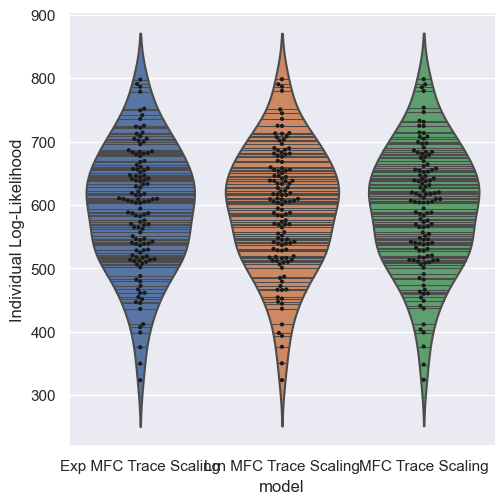

In [7]:
#| code-summary: code -- 3) plot distribution of log-likelihoods across individual subjects

plt.style.use('default')
sns.set(style="darkgrid")

# build individual fits df concatenating results from each model
individual_fits = []
for model_index, model_class in enumerate(models):
    individual_fits.append(
        pd.read_csv(results_path + 'individual_{}_{}.csv'.format(model_names[model_index], section_tag)))
individual_fits = pd.concat(individual_fits, ignore_index=True)

# plot distribution of log-likelihoods across individual subjects
g = sns.catplot(x='model', y='likelihood', data=individual_fits, kind='violin', inner='stick')
sns.swarmplot(x="model", y="likelihood", data=individual_fits, color="k", size=3, ax=g.ax)
g.ax.set_ylabel('Individual Log-Likelihood');
plt.savefig(results_path + 'individual_{}.pdf'.format(section_tag), bbox_inches="tight")

In [8]:
#| code-summary: display markdown rendering of summary table
#| echo: false
#| input: false
#| output: asis

summary_table = pd.DataFrame(group.describe().rename(columns={'likelihood':name}).squeeze()
            for name, group in individual_fits[['model', 'likelihood']].groupby('model')).T.to_markdown()

print("""::: {{#fig-{section_tag}fits layout-nrow=2 layout-valign="center"}}

![]({results_path}individual_{section_tag}.pdf)

{summary_table}

{individual_fits_caption}
:::""".format(section_tag=section_tag, summary_table=summary_table, individual_fits_caption=figure_caption, results_path=results_path))

::: {#fig-Healy_Scaling_Mechanismsfits layout-nrow=2 layout-valign="center"}

![](results/individual_Healy_Scaling_Mechanisms.pdf)

|       |   Exp MFC Trace Scaling |   Lrn MFC Trace Scaling |   MFC Trace Scaling |
|:------|------------------------:|------------------------:|--------------------:|
| count |                126      |                126      |            126      |
| mean  |                592.504  |                592.591  |            591.873  |
| std   |                 96.3633 |                 95.2602 |             95.5635 |
| min   |                323.749  |                323.797  |            324.309  |
| 25%   |                525.767  |                528.95   |            527.891  |
| 50%   |                604.362  |                605.388  |            604.274  |
| 75%   |                657.711  |                655.794  |            655.678  |
| max   |                798.017  |                798.623  |            798.662  |

Distribution of log-likelih

In [9]:
#| code-summary: perform t-tests on individual-level fits
#| output: false
 
from scipy.stats import ttest_rel
import itertools

for combination in itertools.combinations(pd.unique(individual_fits.model), 2):

    print(combination)
    print(ttest_rel(individual_fits[individual_fits.model == combination[0]].likelihood, individual_fits[individual_fits.model == combination[1]].likelihood, alternative='two-sided'))
    print(ttest_rel(individual_fits[individual_fits.model == combination[0]].likelihood, individual_fits[individual_fits.model == combination[1]].likelihood, alternative='less'))
    print(ttest_rel(individual_fits[individual_fits.model == combination[0]].likelihood, individual_fits[individual_fits.model == combination[1]].likelihood, alternative='greater'))
    print()

('Exp MFC Trace Scaling', 'Lrn MFC Trace Scaling')
Ttest_relResult(statistic=-0.052118243940039784, pvalue=0.9585176733074144)
Ttest_relResult(statistic=-0.052118243940039784, pvalue=0.4792588366537072)
Ttest_relResult(statistic=-0.052118243940039784, pvalue=0.5207411633462928)

('Exp MFC Trace Scaling', 'MFC Trace Scaling')
Ttest_relResult(statistic=0.592346755763144, pvalue=0.5546883986983966)
Ttest_relResult(statistic=0.592346755763144, pvalue=0.7226558006508017)
Ttest_relResult(statistic=0.592346755763144, pvalue=0.2773441993491983)

('Lrn MFC Trace Scaling', 'MFC Trace Scaling')
Ttest_relResult(statistic=0.5200783283381096, pvalue=0.6039288420878326)
Ttest_relResult(statistic=0.5200783283381096, pvalue=0.6980355789560837)
Ttest_relResult(statistic=0.5200783283381096, pvalue=0.3019644210439163)



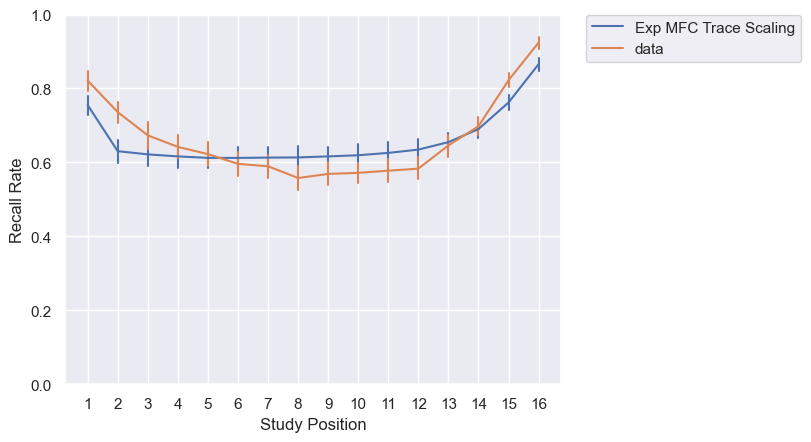

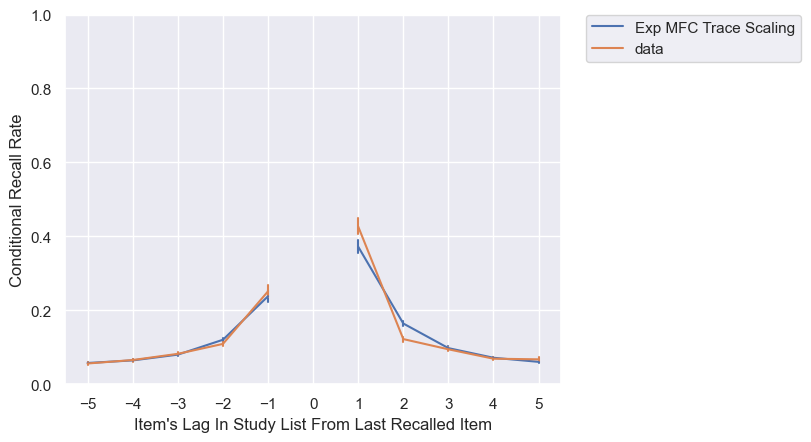

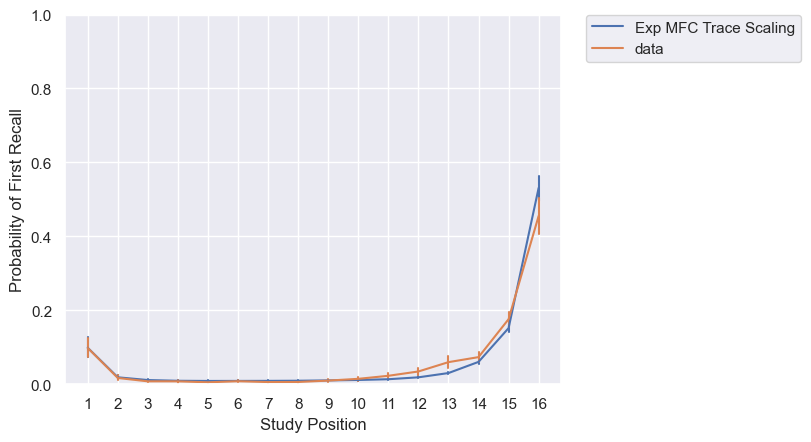

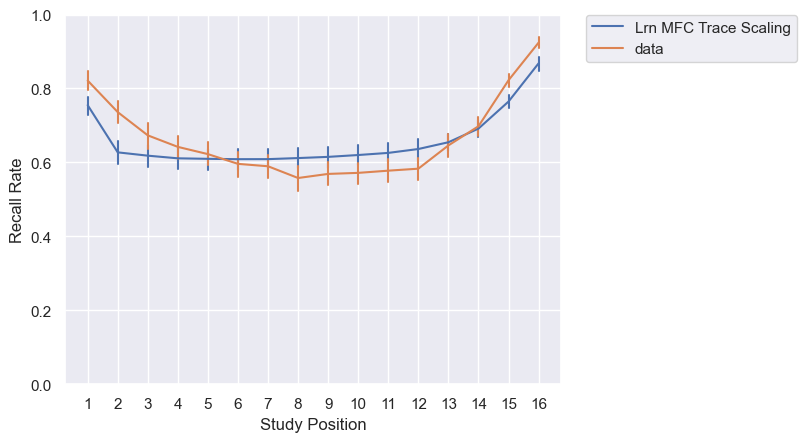

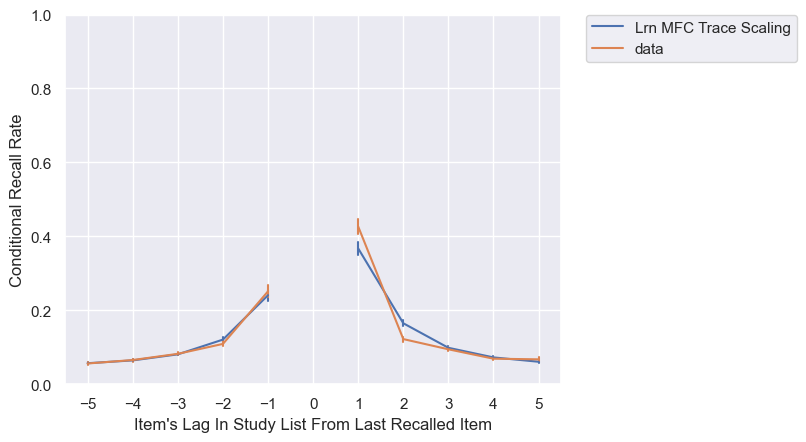

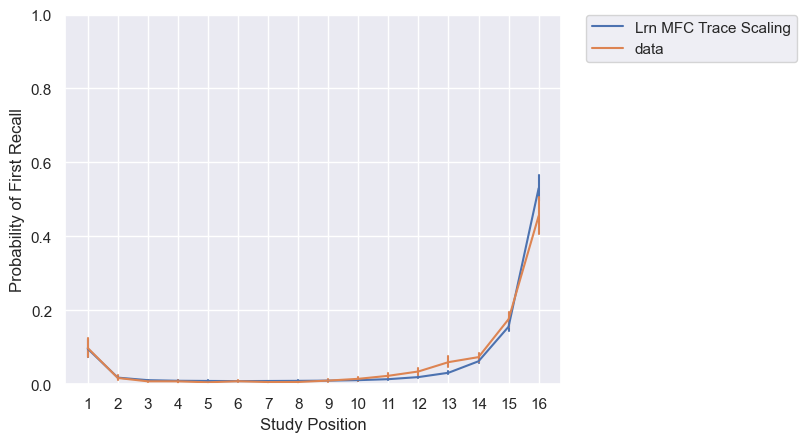

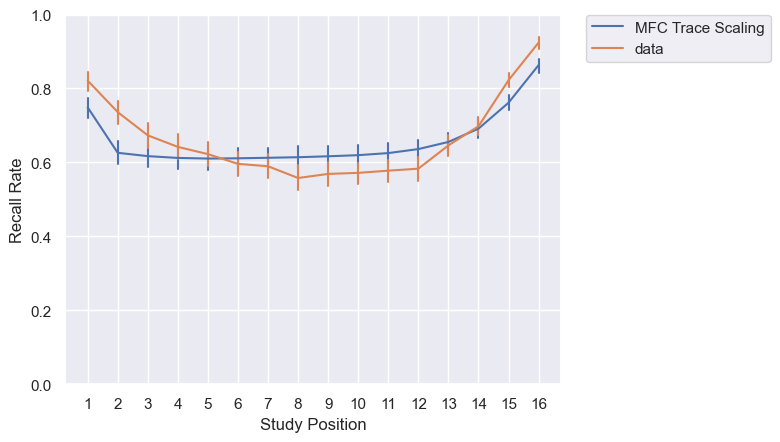

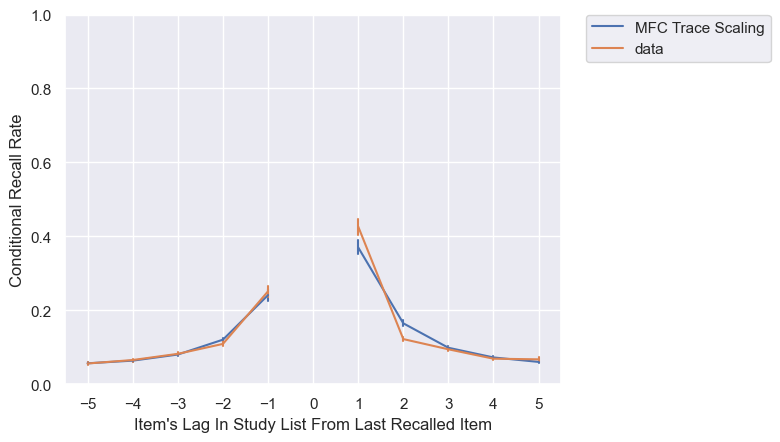

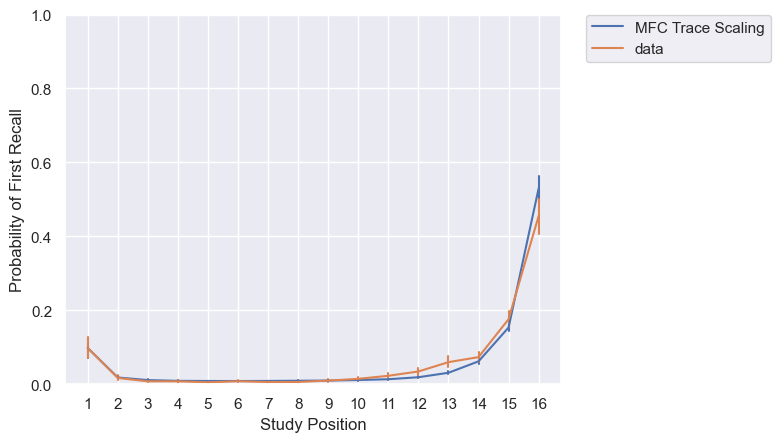

In [10]:
sns.set(style='darkgrid')

# for each unique list length
if not (isinstance(list_lengths, list) or isinstance(list_lengths, List)): 
    list_lengths = [list_lengths]

for figure_index, list_length in enumerate(list_lengths):

    #fig, axes = plt.subplots(nrows=len(models), ncols=3, figsize=(15, int(4*len(models))), sharey=False)
    
    # for each unique model
    for model_index, model_class in enumerate(models):

        # load sim_df from csv if it exists
        sim_df_path = results_path + 'sim_df_{}_{}_ll{}.csv'.format(model_names[model_index], section_tag, list_length)
        if os.path.isfile(sim_df_path):
            sim_df = pd.read_csv(sim_df_path)
            print('sim_df for {} with tag {} and list length {} already exists'.format(model_names[model_index], section_tag, list_length))

        # otherwise, generate it
        else:

            # for each unique matching entry in individual df
            sim_dfs = []
            for subject in pd.unique(individual_fits.subject):
                
                fit_result = individual_fits.query(f'subject == {subject} & model == "{model_names[model_index]}"')

                # configure model based on specified parameters
                fitted_parameters = Dict.empty(
                    key_type=types.unicode_type, value_type=types.float64
                )
                for i in range(len(free_parameters[model_index])):
                    fitted_parameters[free_parameters[model_index][i]] = fit_result[free_parameters[model_index][i]].values[0]
                for key in fixed_parameters[model_index]:
                    fitted_parameters[key] = fixed_parameters[model_index][key]

                # simulate df based on specified trial_count and experiment_count
                model = model_class(list_length, list_length, fitted_parameters)
                sim_dfs.append(simulate_df(model, fit_result['trial_count'].values[0] * experiment_count))
                sim_dfs[-1].list = sim_dfs[-1].subject
                sim_dfs[-1].subject = subject

            # concatenate simulations into one dataframe
            sim_df = pd.concat(sim_dfs)

            # save sim_df to csv
            sim_df.to_csv(results_path + 'sim_df_{}_{}_ll{}.csv'.format(model_names[model_index], section_tag, list_length), index=False)

        # obtain parallel true_df structure
        if len(list_lengths) > 1:
            true_df = events.query(trial_query).query(f'`list length` == {list_length}')
        else:
            true_df = events.query(trial_query)

        sim_spc = apply_and_concatenate(
                fr.spc,
                sim_df,
                true_df,
                contrast_name="source",
                labels=[model_names[model_index], "data"],
            )

        sim_lag_crp = apply_and_concatenate(
                fr.lag_crp,
                sim_df,
                true_df,
                "source",
                labels=[model_names[model_index], "data"],
            )

        sim_pfr = apply_and_concatenate(
                fr.pnr,
                sim_df,
                true_df,
                contrast_name="source",
                labels=[model_names[model_index], "data"],
            )
        sim_pfr = sim_pfr.query("output <= 1")

        # serial position curve
        analysis_name = 'spc'
        plt.figure()
        axis = plt.gca()
        sns.lineplot(ax=axis, data=sim_spc, x='input', y='recall', err_style='bars', hue='source')
        axis.set(xlabel='Study Position', ylabel='Recall Rate')
        axis.set_xticks(np.arange(1, list_length+int(list_length/10), int(list_length/10)))
        axis.set_ylim((0, 1))
        axis.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.savefig(f'{results_path}{analysis_name}_{section_tag}_{model_names[model_index]}_length_{list_length}.pdf', bbox_inches='tight')

        # lag crp curve
        analysis_name = 'crp'
        plt.figure()
        axis = plt.gca()
        max_lag = 5
        filt_neg = f'{-max_lag} <= lag < 0'
        filt_pos = f'0 < lag <= {max_lag}'

        sns.lineplot(ax=axis, data=sim_lag_crp.query(filt_neg), x='lag', y='prob', 
                    err_style='bars', hue='source', legend=False)
        sns.lineplot(ax=axis, data=sim_lag_crp.query(filt_pos), x='lag', y='prob', 
                    err_style='bars', hue='source')
        axis.set(xlabel='Item\'s Lag In Study List From Last Recalled Item', ylabel='Conditional Recall Rate')
        axis.set_xticks(np.arange(-5, 6, 1))
        axis.set_ylim((0, 1))
        axis.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.savefig(f'{results_path}{analysis_name}_{section_tag}_{model_names[model_index]}_length_{list_length}.pdf', bbox_inches='tight')


        # pfr
        analysis_name = 'pfr'
        plt.figure()
        axis = plt.gca()
        sns.lineplot(data=sim_pfr, x='input', y='prob', err_style='bars', ax=axis, hue='source')
        axis.set(xlabel='Study Position', ylabel='Probability of First Recall')
        axis.set_xticks(np.arange(1, list_length+int(list_length/10), int(list_length/10)))
        axis.set_ylim((0, 1))

        # set legend of axis 2 outside the plot, to the right
        axis.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.savefig(f'{results_path}{analysis_name}_{section_tag}_{model_names[model_index]}_length_{list_length}.pdf', bbox_inches='tight')